In [2]:
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import linregress

#A) Data Obtention

Now we're going to download the required asset's data 

In [4]:
Btc = yf.download("BTC-USD", start="2023-12-13", end="2023-12-14", interval="1m")
Ltc = yf.download("LTC-USD", start="2023-12-13", end="2023-12-14", interval="1m")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
Btc.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-12-13 00:00:00+00:00,41468.464844,41468.464844,41468.464844,41468.464844,41468.464844,0
2023-12-13 00:01:00+00:00,41461.472656,41461.472656,41461.472656,41461.472656,41461.472656,0
2023-12-13 00:02:00+00:00,41453.640625,41453.640625,41453.640625,41453.640625,41453.640625,0
2023-12-13 00:03:00+00:00,41411.753906,41411.753906,41411.753906,41411.753906,41411.753906,0
2023-12-13 00:04:00+00:00,41399.691406,41399.691406,41399.691406,41399.691406,41399.691406,4345856


In [6]:
Ltc.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-12-13 00:00:00+00:00,72.404373,72.404373,72.404373,72.404373,72.404373,0
2023-12-13 00:01:00+00:00,72.397957,72.397957,72.397957,72.397957,72.397957,0
2023-12-13 00:02:00+00:00,72.393661,72.393661,72.393661,72.393661,72.393661,0
2023-12-13 00:03:00+00:00,72.385994,72.385994,72.385994,72.385994,72.385994,0
2023-12-13 00:04:00+00:00,72.323257,72.323257,72.323257,72.323257,72.323257,0


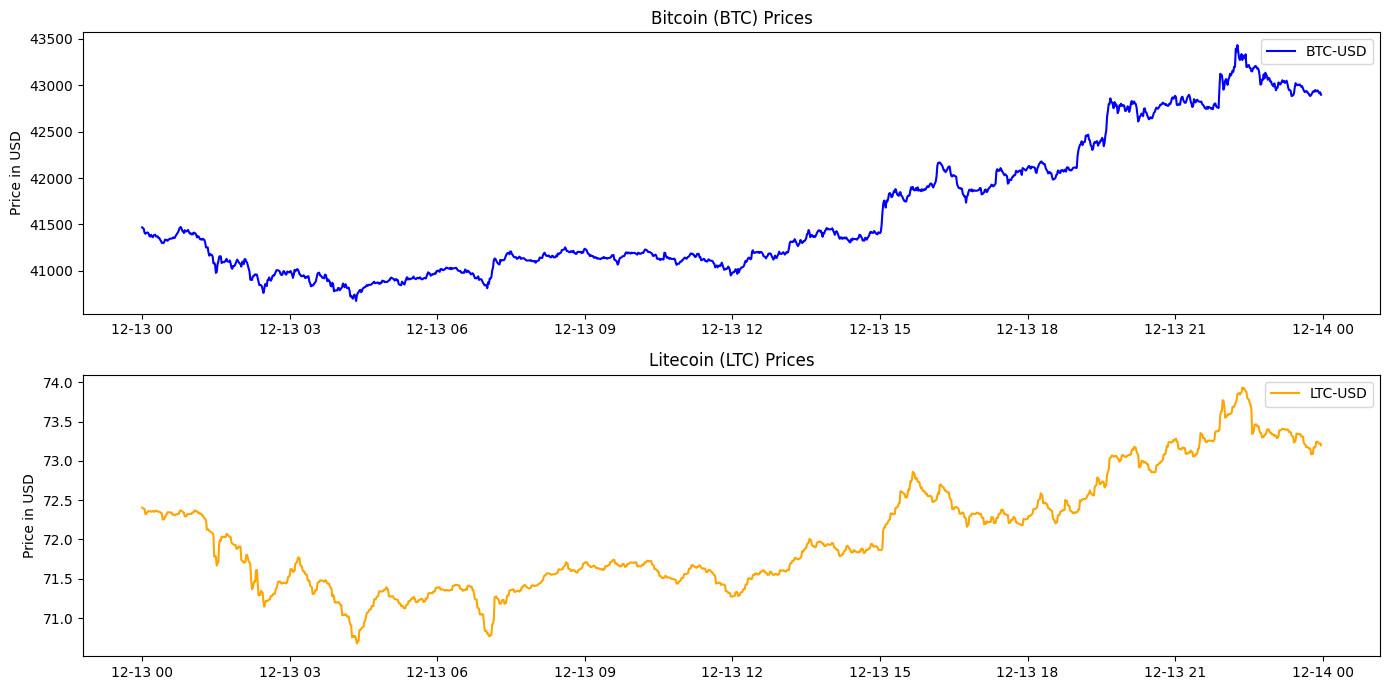

In [7]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(Btc.index, Btc['Close'], label='BTC-USD', color='blue')
plt.title('Bitcoin (BTC) Prices')
plt.ylabel('Price in USD')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Ltc.index, Ltc['Close'], label='LTC-USD', color='orange')
plt.title('Litecoin (LTC) Prices')
plt.ylabel('Price in USD')
plt.legend()

plt.tight_layout()
plt.show()

B) Parameter Estimation

Now we're going to assume the delta or the pairs strategy to determine the Rho which is the correlation between the two underlying assets

We firstly proceed to determine the Strike price to estimate the returns 

In [8]:
S1_0 = Btc['Open'][0]
S2_0 = Ltc['Open'][0]
r1 = np.log(Btc['Adj Close']/Btc['Adj Close'].shift(1))
r2 = np.log(Ltc['Adj Close']/Ltc['Adj Close'].shift(1))

Now we proceed to calculate the correlation between the returns of both of our underlying assets

In [9]:
delta = 1 # delta is also called negative speed mean reversion, is how quick the prices reverses to its original value, is also the negative of alpha, alpha is the speed of mean reversion 

# Rho is the correlation estimations between the cointegrated asset's returns
rho = r1.corr(r2)

rho

0.2115459624728051

C) Beta Selection 

We proceed to choose a beta, however we calculate the beta as seen in the class lectures/ revision

In [10]:
# we are obtaining Beta by using a linear regression between our 2 stocks, in the stationary process.
result = linregress(np.log(Btc['Adj Close']),np.log(Ltc['Adj Close']))
beta = result.slope

beta

0.5546716087952333

In [11]:
mu_1 = r1.mean()*1440
mu_2 = r2.mean()*1440
sigma_1 = r1.std()*np.sqrt(1440)
sigma_2 = r2.std()*np.sqrt(1440)
Z_0 = 0 # we assume that both assets are cointegrated and have a stationary linear relation, you can do tests to estimate this

# Gamma is the risk tolerance, how risk averse our investors are
gamma = 0.5

# now our time range and intervals
T = 1 # for we only have 1 trading day for our underlying assets
M = 1440 # This is the minutely intervals existing in a trading day for Cryptocurrency Assets 

C) Inputs Discuss (S, mu, sigma)

E & F) Optimal Trading Weights & Cash processes obtention

In [12]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
Z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

In [13]:
tt = np.linspace(0, 1, M + 1)
Z[0] = Z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(Z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    Z[t] = Z[t-1]* (1 - delta * (eta - Z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * Z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

Text(0.5, 1.0, 'Crypto Price')

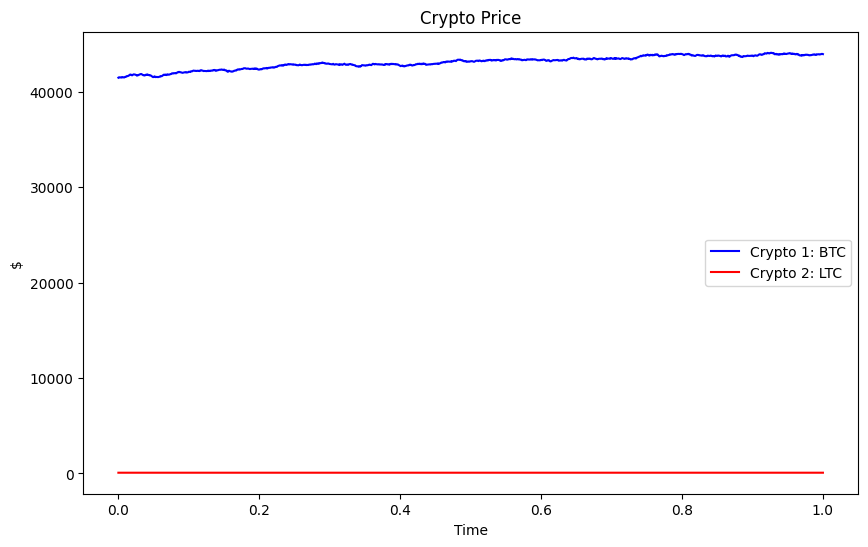

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='Crypto 1: BTC')
plt.plot(tt, S2, 'r', lw=1.5, label='Crypto 2: LTC')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Crypto Price')

Text(0.5, 1.0, 'Crypto Price')

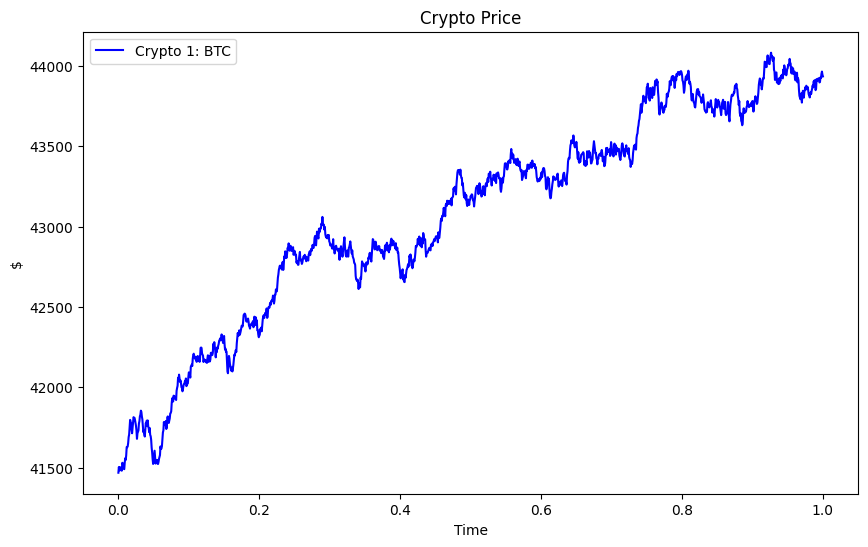

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='Crypto 1: BTC')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Crypto Price')

Text(0.5, 1.0, 'Crypto Price')

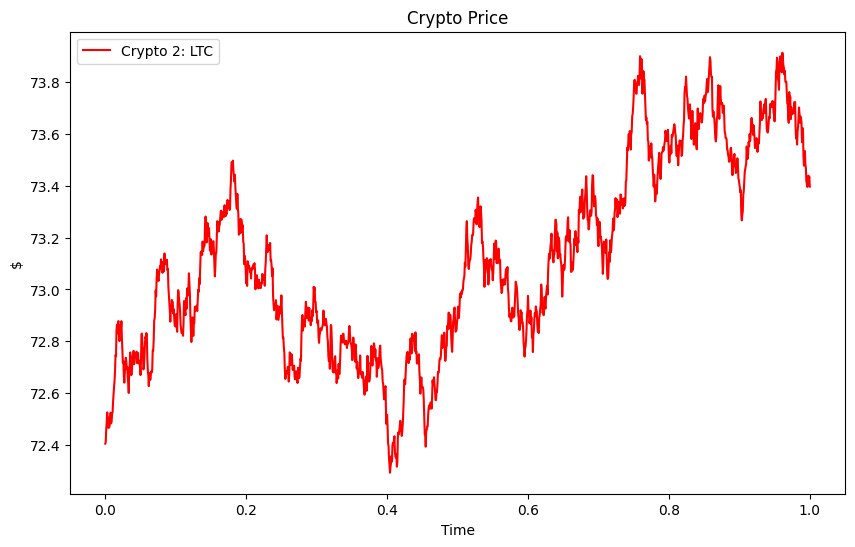

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S2, 'r', lw=1.5, label='Crypto 2: LTC')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Crypto Price')

Text(0.5, 1.0, 'Alpha')

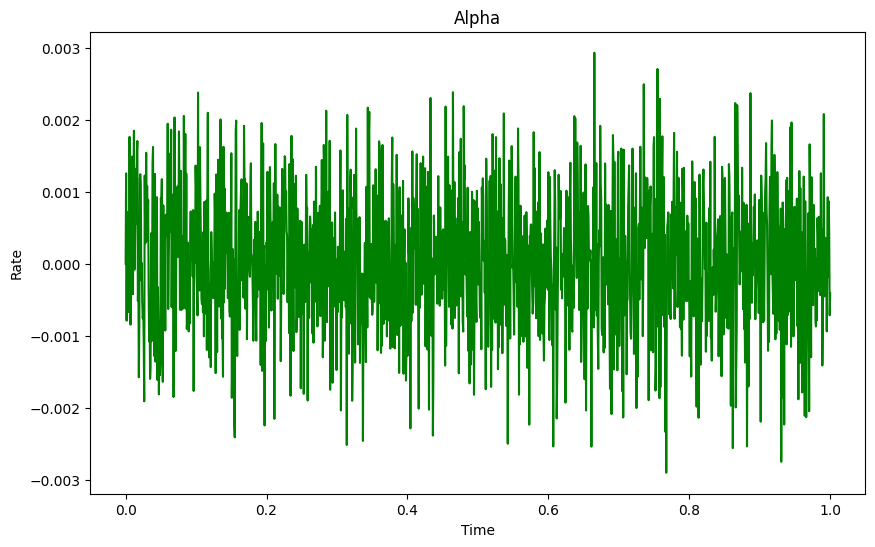

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Alpha')

In [18]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * Z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * Z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * Z[t]) - b[t]) - rho * (mu_1 + delta * Z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Weights')

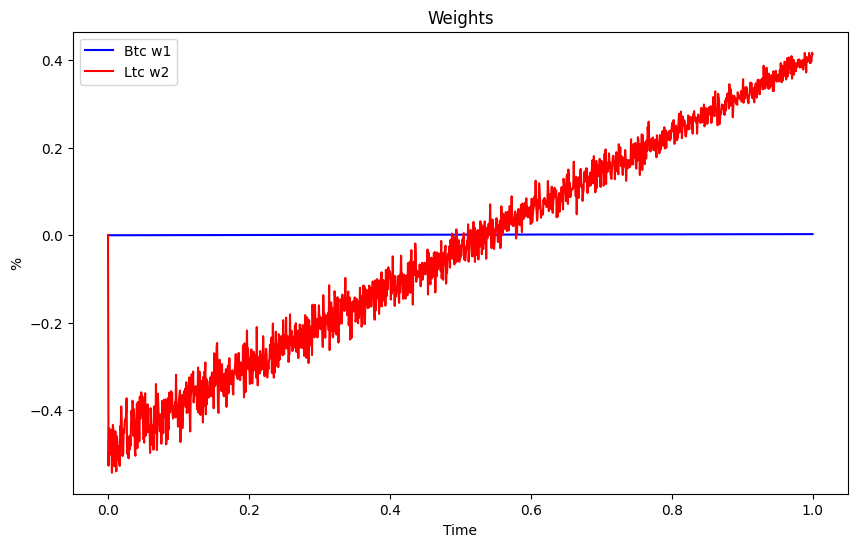

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='Btc w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='Ltc w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Cash')

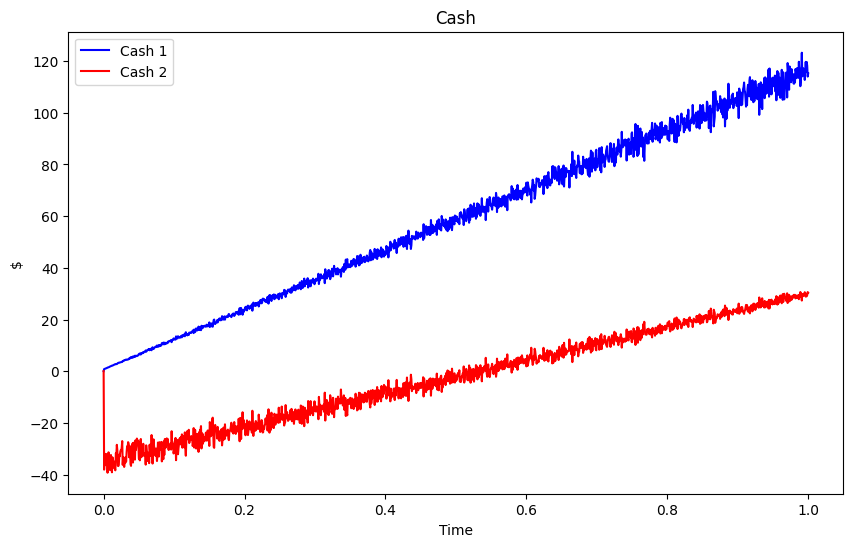

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Cash 1')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Cash 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Cash')

In [21]:
Pi_1.mean()

0.0013495912251657804

In [22]:
Pi_2.mean()

-0.03264219902298538

G) STATIC CONTROL PAIR COMPARISON

Text(0.5, 1.0, 'Comparison')

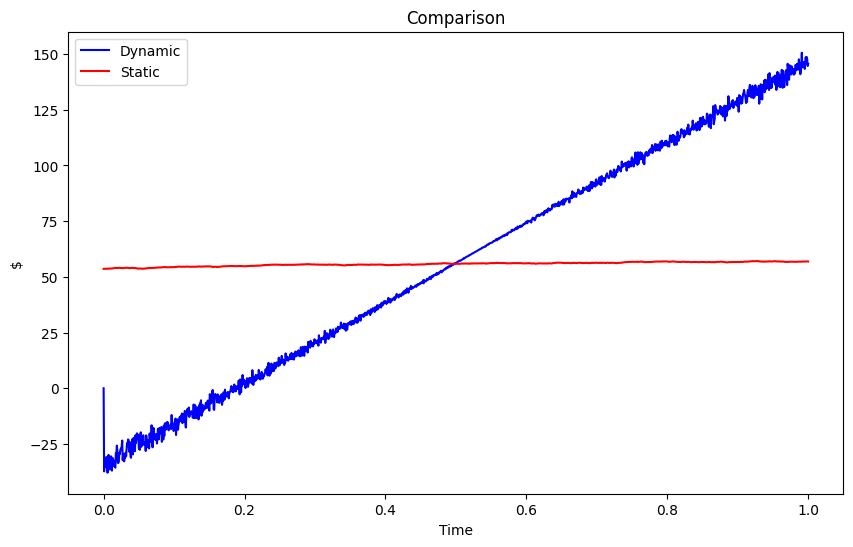

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')

H) ASSETS SIMULATION

We chose to simulate other 2 correlated assets, and redo our steps to get the two optimal factors. I chose to do this simulation by

step a)

In [24]:
Tsla = yf.download("TSLA", start="2023-12-13", end="2023-12-14", interval="1m")
F = yf.download("F", start="2023-12-13", end="2023-12-14", interval="1m")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [25]:
Tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-12-13 09:30:00-05:00,234.190002,235.449997,234.000000,235.195007,235.195007,3152770
2023-12-13 09:31:00-05:00,235.228699,235.899994,234.449997,235.820007,235.820007,683952
2023-12-13 09:32:00-05:00,235.820801,235.839996,235.100006,235.581497,235.581497,446400
2023-12-13 09:33:00-05:00,235.539993,236.440002,235.490097,236.255203,236.255203,646534
2023-12-13 09:34:00-05:00,236.250000,236.839996,236.230103,236.590698,236.590698,576287


In [26]:
F.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-12-13 09:30:00-05:00,11.030,11.0700,11.030,11.0450,11.0450,857803
2023-12-13 09:31:00-05:00,11.040,11.0500,11.020,11.0399,11.0399,1006785
2023-12-13 09:32:00-05:00,11.035,11.0400,11.025,11.0300,11.0300,139834
2023-12-13 09:33:00-05:00,11.034,11.0500,10.980,10.9850,10.9850,436167
2023-12-13 09:34:00-05:00,10.980,11.0174,10.980,10.9950,10.9950,313055


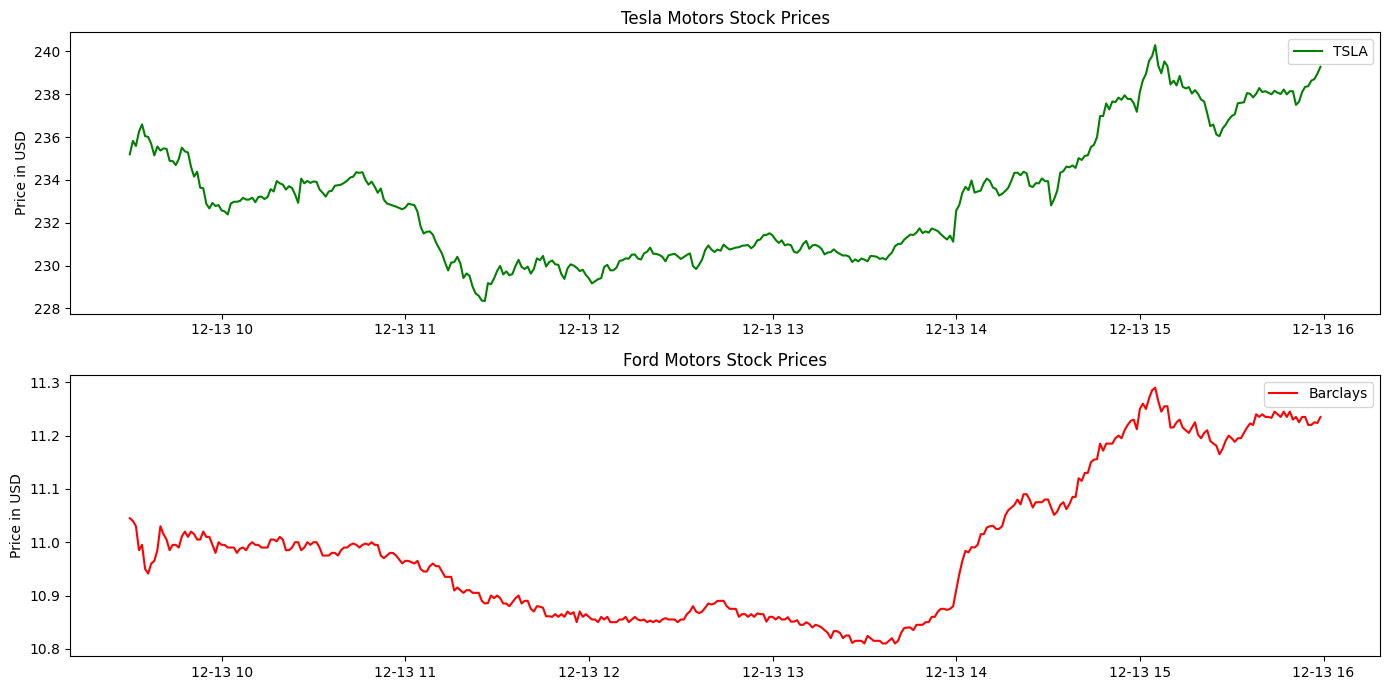

In [27]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(Tsla.index, Tsla['Close'], label='TSLA', color='green')
plt.title('Tesla Motors Stock Prices')
plt.ylabel('Price in USD')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(F.index, F['Close'], label='Barclays', color='red')
plt.title('Ford Motors Stock Prices')
plt.ylabel('Price in USD')
plt.legend()

plt.tight_layout()
plt.show()

step b)

In [85]:
S1_0 = Tsla['Open'][0] # Asset 1 initial price 
S2_0 = F['Open'][0]    # Asset 2 initial price 
mu_1 = 0.03    # We decided to use this 𝜇 as the average spread of the tesla stock
mu_2 = 0.016   #We decided to use this 𝜇 as the average spread of the Ford stock
sigma_1 = 0.35 # As we can observe in the data, Tesla stock prices have a higher sensitivy to shocks, ergo we assume higher volatility
sigma_2 = 0.16 # As we can observe in the data, Ford stock prices have a lower sensitivy to shocks, ergo we assume lower volatility
Z_0 = 0.01     # we assume that both assets are cointegrated and have a stationary linear relation, you can do tests to estimate this
beta = 0.85    # Even though both companies are in the motor car industry, it's observable that Tesla is more volatile than Ford
gamma = 0.5    # Gamma is the risk tolerance, how risk averse our investors are
delta = 1      # Delta is the negative of the speed of mean reversion, is how quick the prices reverses to its original value, is also the negative of alpha, alpha is the speed of mean reversion 
phi = 0.01     # Portfolio fees and costs
rho = 0.83     # Co-integrated assets correlation
T = 1          # for we only have 1 trading day for our underlying assets
M = 390        # This is the minutely intervals existing in a trading day for Stock Mkt. Assets

In [86]:
S1 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
S1[0] = S1_0 
rn1 = np.random.standard_normal(S1.shape) 
for t in range(1, N + 1): 
    S1[t] = S1[t-1] + sigma_1 * np.sqrt(T/N) * rn1[t]

In [87]:
S2 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
S2[0] = S2_0 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, N + 1): 
    S2[t] = S2[t-1] + sigma_2 * np.sqrt(T/N) * rn2[t]

Text(0.5, 1.0, 'Tesla Stock Price')

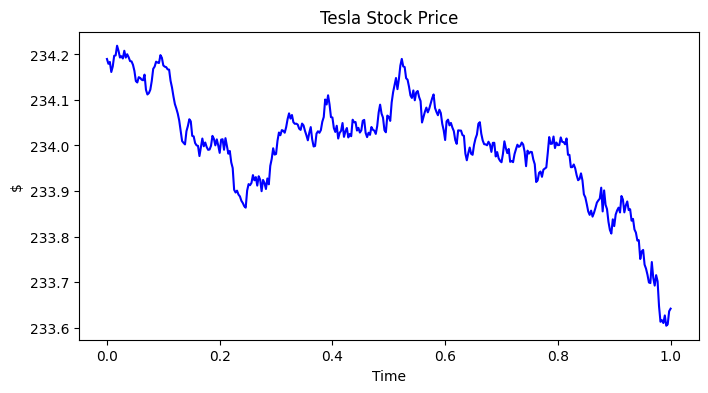

In [88]:
plt.figure(figsize=(8, 4))
plt.plot(tt, S1, 'b', lw=1.5)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Tesla Stock Price')

Text(0.5, 1.0, 'Ford Stock Price')

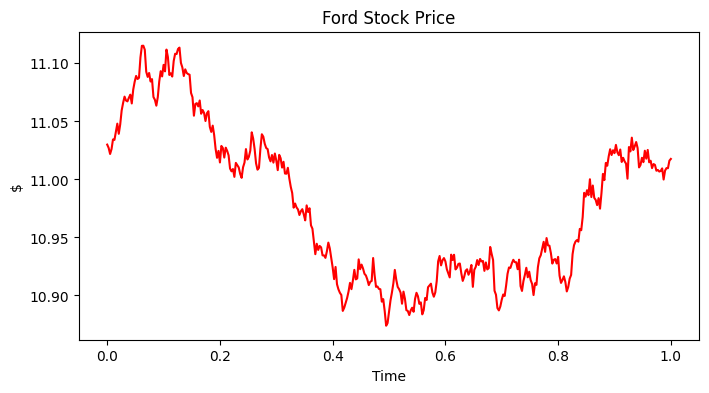

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(tt, S2, 'r', lw=1.5)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Ford Stock Price')

CALCULATE RETURNS

In [90]:
r1 = np.zeros(S1.shape)  # Array to hold the returns
for t in range(1, N + 1):
    r1[t] = (S1[t] - S1[t-1]) / S1[t-1]

In [91]:
r2 = np.zeros(S2.shape)  # Array to hold the returns
for t in range(1, N + 1):
    r2[t] = (S2[t] - S2[t-1]) / S2[t-1]

In [92]:
r1 = np.log(Tsla['Adj Close']/Tsla['Adj Close'].shift(1))
r2 = np.log(F['Adj Close']/F['Adj Close'].shift(1))
# delta is also called negative speed mean reversion, is how quick the prices reverses to its original value, is also the negative of alpha, alpha is the speed of mean reversion 
delta = 1
# Rho is the correlation estimations between the cointegrated asset's returns
rho = r1.corr(r2)

rho

0.3884020633100182

step c)

In [93]:
# we are obtaining Beta by using a linear regression between our 2 stocks, in the stationary process.
result = linregress(np.log(Tsla['Adj Close']),np.log(F['Adj Close']))
beta = result.slope
beta

0.9321140787596107

In [94]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
Z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

In [95]:
tt = np.linspace(0, 1, M + 1)
Z[0] = Z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(Z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    Z[t] = Z[t-1]* (1 - delta * (eta - Z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * Z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

Text(0.5, 1.0, 'Stock Price')

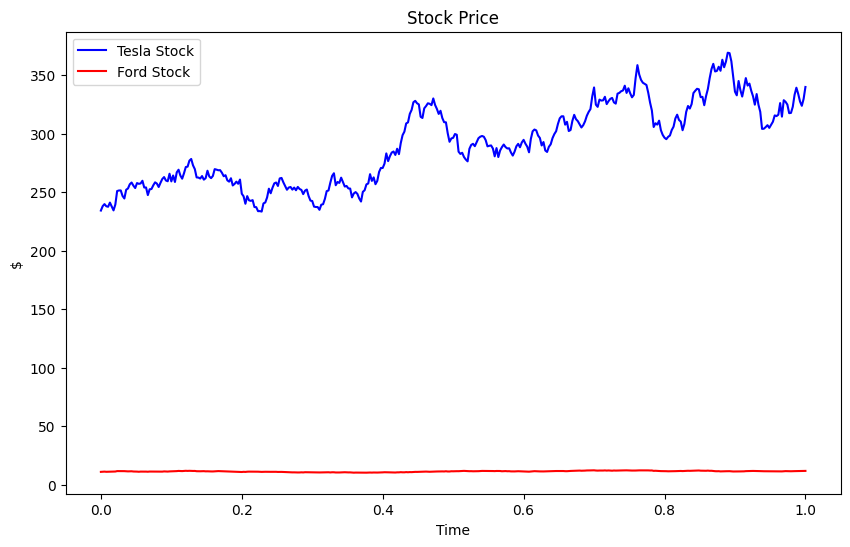

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='Tesla Stock')
plt.plot(tt, S2, 'r', lw=1.5, label='Ford Stock')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Stock Price')

Text(0.5, 1.0, 'Stock Price')

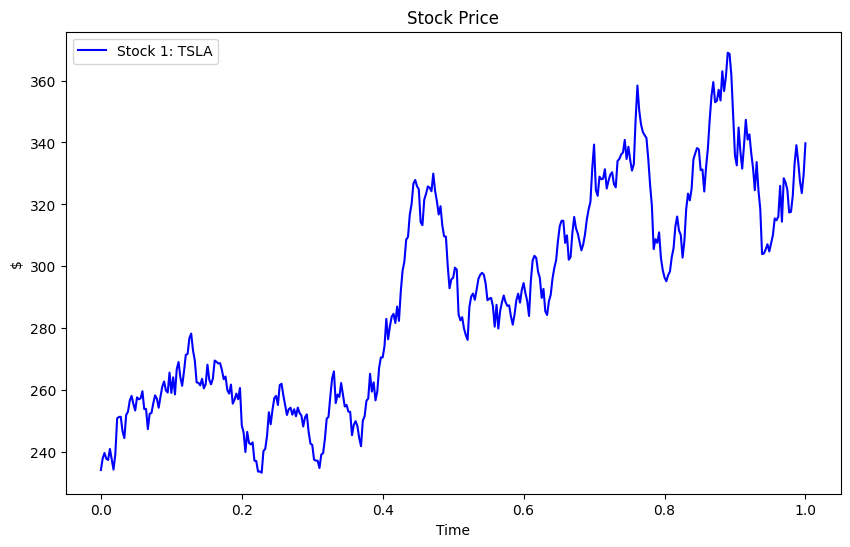

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='Stock 1: TSLA')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Stock Price')

Text(0.5, 1.0, 'Stock Price')

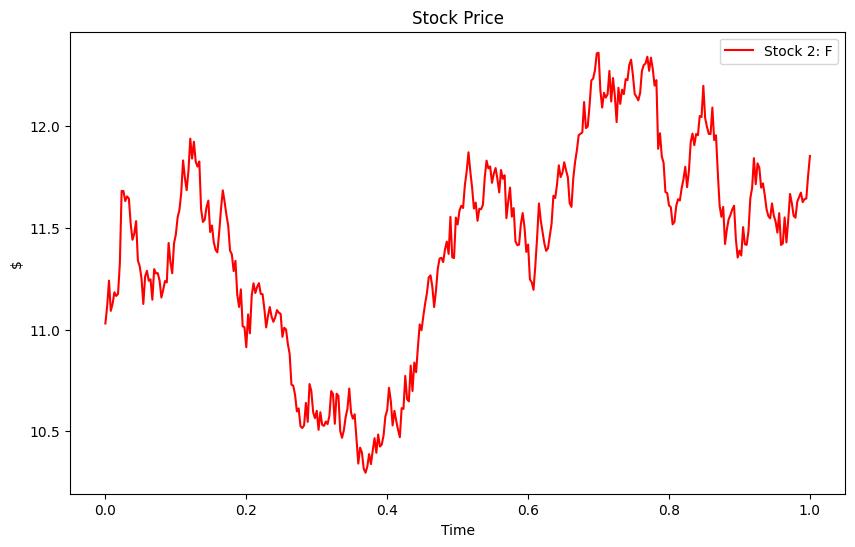

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S2, 'r', lw=1.5, label='Stock 2: F')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Stock Price')

Text(0.5, 1.0, 'Alpha')

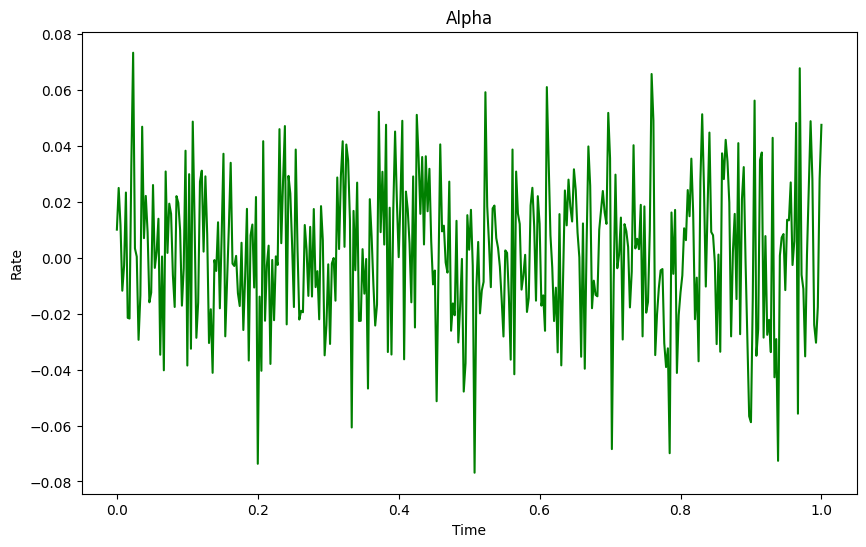

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Alpha')

In [100]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * Z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * Z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * Z[t]) - b[t]) - rho * (mu_1 + delta * Z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Weights')

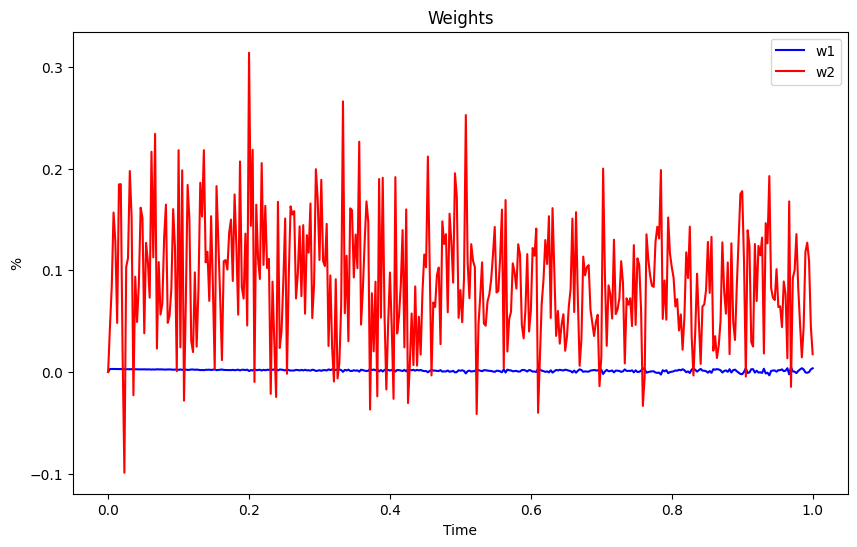

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Cash')

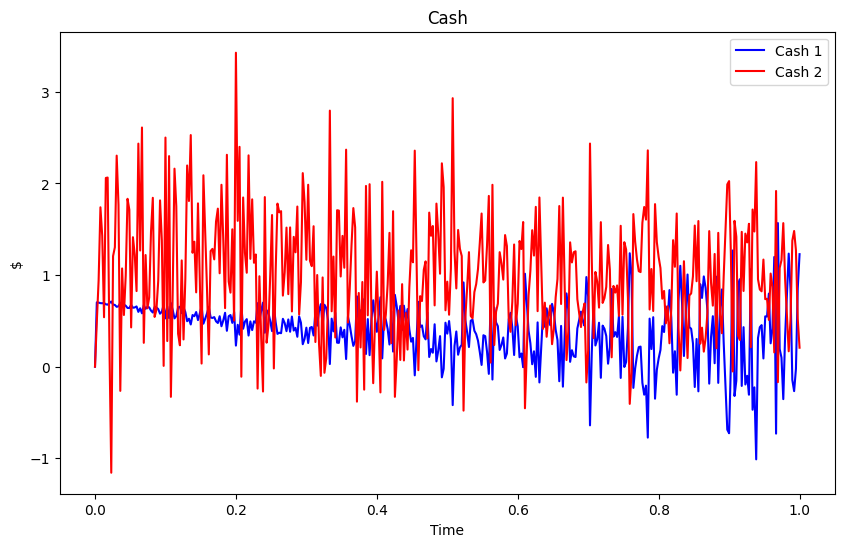

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Cash 1')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Cash 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Cash')

In [103]:
Pi_1.mean()

0.0014423988317716324

In [104]:
Pi_2.mean()

0.08865231948372165

Text(0.5, 1.0, 'Comparison')

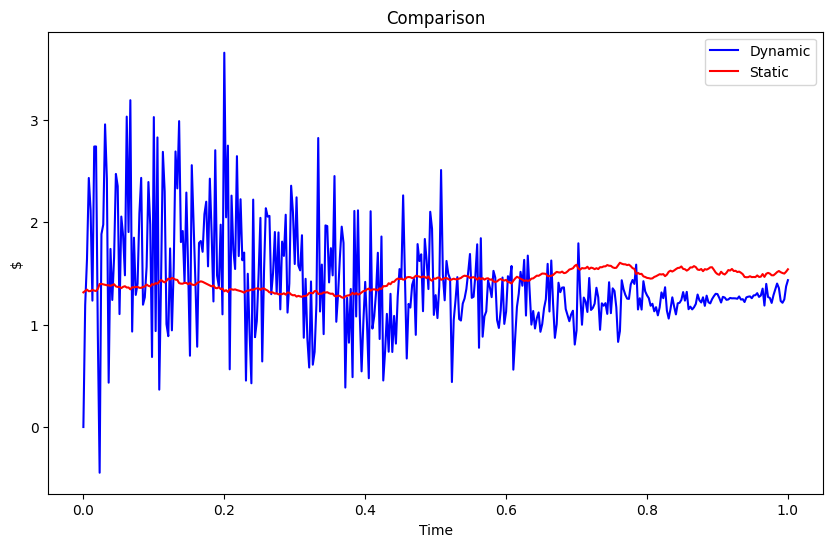

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')